# Final Project Submission

**Please fill out:**
* Student name: Cameryn
* Student pace: part time
* Scheduled project review date/time: 3/24/20 - 4:00 PM
* Instructor name: Victor Geislinger
* Blog post URL: https://medium.com/@camerynrhosyn/merging-datasets-as-data-cleaning-beda3d569c9b?sk=5f180933874ed992130f2f14e36ef737


---

## Table of Contents:
 - [Importing Packages](#Importing-Packages)
 - [Importing CSV and TSV Files](#Importing-CSV-and-TSV-Files)
 - [Functions](#Functions)
     - [Column Type Function](#Column-Type-Function)
     - [Quick Check Function](#Quick-Check-Function)
     - [Make DataFrame Function](#Make-DataFrame-Function)
     - [Table Creator Function](#Table-Creator-Function)
 - [Data Cleaning](#Data-Cleaning)
     - [Box Office Mojo Data](#Box-Office-Mojo-Data)
     - [IMDb Data](#IMDb-Data)
     - [Rotten Tomatoes Data](#Rotten-Tomatoes-Data)
     - [TMDb Data](#TMDb-Data)
 - [Creating the Database](#Creating-the-Database)
 - [Visualizations](#Visualizations)
     - [Content Data Visualization](#Content-Data-Visualization)
     - [Personnel Data Visualization](#Personnel-Data-Visualization)
     - [Financial Data Visualization](#Financial-Data-Visualization)

---

# Importing Packages
For this project, the pandas, numpy, seaborn, matplotlib, and sqlite3 packages are needed and imported. The matplotlib is also declared as inline to avoid any potential issues in the future.

In [1]:
import pandas as pd # for dataframes
import numpy as np # for scientific computing
import matplotlib.pyplot as plt #for plotting
import seaborn as sns # for making our charts more readable
import sqlite3 # database
from sqlalchemy import create_engine # moving data from df to db

%matplotlib inline

---

# Importing CSV and TSV Files

First, it is important to bring all of the data into a usable, readable format, in this case, pandas dataframes.

**Note that one file, 'rt.reviews.tsv' is encoded differently and thus needed to be converted using the correct encoding declaration.**

In [2]:
#Import data
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv')
im_n_basics_df = pd.read_csv('zippedData/imdb.name.basics.csv')
im_akas_df = pd.read_csv('zippedData/imdb.title.akas.csv')
im_basics_df = pd.read_csv('zippedData/imdb.title.basics.csv')
im_crew_df = pd.read_csv('zippedData/imdb.title.crew.csv')
im_principals_df = pd.read_csv('zippedData/imdb.title.principals.csv')
im_ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv', sep='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t', encoding = 'latin1')
tmdb_movies_df = pd.read_csv('zippedData/tmdb.movies.csv')
tn_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv')

After importing them, the .info() of each dataframe was checked in order to determine the data types of each column and determine what needed to be done in the below cells. That is not shown below for each dataframe, simply due to the amount of space that does take, but it is shown for the first dataframe, bom_df.

**Note the 'foreign_gross' column's type. This will prevent future statistical analysis, which is addressed in the future.**

---

# Functions

## Column Type Function
The below functions have been written to prevent unnecessary repetition.

In [3]:
def column_type_changer(column, df):
    """Returns stripped, numeric column from object-type column
       Args:
           column: Column to be converted.
           df: DataFrame that column is located in.
       Returns:
           Series data converted to numeric data type"""
    
    df[column] = df[column].str.replace('$','') # Removing non-numeric chars
    df[column] = df[column].str.replace(',','') # Removing non-numeric chars
    df[column] = df[column].str.replace(' minutes','') # Removing non-numeric chars
    df[column] = df[column].apply(pd.to_numeric) # Converts to numbers
    return df[column]

## Quick Check Function
To allow for quick checks of duplicated rows, missing data, and any odd statistics, the below function was created. It is pretty self-explanatory, but makes the process a bit simpler.

In [4]:
def quick_check(df):
    """Returns dataframe, unchanged, but prints vitals of dataframe
       Args:
           df: Dataframe for evaluation"""
    print("**SUM of NA Values**")
    print(df.isna().sum())
    print("**Duplicated Rows**")
    print(df[df.duplicated()])
    print("**Dataframe Statistics:**")
    print(df.describe())
    return(df)

## Make DataFrame Function
This function prevents the user from needing to go through the process of creating dataframes over and over every time there is one that needs to be created from a sql query.

In [5]:
def make_dataframe():
    """Returns dataframe from SQL Query"""
    df = pd.DataFrame(cur.fetchall())
    df.columns = [x[0] for x in cur.description]
    return(df)

## Table Creator Function
Creates tables based on dataframes in pipeline.

In [6]:
def table_creator(df, table_name):
    """Writes to SQL database tables from dataframes."""
    df.to_sql(table_name, con=engine)
    engine.execute("""SELECT * from {}""".format(table_name)).fetchall()

---

# Data Cleaning
In order to appropriately understand and interpret each dataframe in the context of the others, it is important to clean and appropriately format each column, removing unhelpful and ill-formated data and replacing where possible.

Duplicates will be removed next, and then null values will be dealt with, looking for contextual reasons for missing data.

### Box Office Mojo Data

In [7]:
bom_df.info() # Checking column types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


Due to the `foreign_gross` column's type, it is necessary to convert it to a numeric type.

In [8]:
bom_df['foreign_gross'] = column_type_changer('foreign_gross', bom_df)

In [9]:
quick_check(bom_df)

**SUM of NA Values**
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [title, studio, domestic_gross, foreign_gross, year]
Index: []
**Dataframe Statistics:**
       domestic_gross  foreign_gross         year
count    3.359000e+03   2.037000e+03  3387.000000
mean     2.874585e+07   7.487281e+07  2013.958075
std      6.698250e+07   1.374106e+08     2.478141
min      1.000000e+02   6.000000e+02  2010.000000
25%      1.200000e+05   3.700000e+06  2012.000000
50%      1.400000e+06   1.870000e+07  2014.000000
75%      2.790000e+07   7.490000e+07  2016.000000
max      9.367000e+08   9.605000e+08  2018.000000


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


Note the number of null objects in the 'foreign_gross' column. This could be attributed to a number of things, though often it could simply be that the film wasn't released abroad. Without context, it may cause more problems that it would solve to replace that information. Further exploration of the other data may be necessary.
More importantly, note the number of NA values in domestic gross. As Microsoft is likely going to be focused on domestically-valuable films, we can safely drop the few films with no data in that column.

In [10]:
# Removing lines with NA in Domestic Gross
bom_df.dropna(subset=['domestic_gross'],inplace=True)

# Checking for NA Values
bom_df.isna().sum()

title                0
studio               3
domestic_gross       0
foreign_gross     1350
year                 0
dtype: int64

### IMDb Data

**Setting Indices**

IMDb's data does utilize constants for each unique title and person, which is why each dataframe will have the appropriate constant set as its index. This does two things: it prevents excess data from being pushed over to the SQLite database in the future in the form of unnecessary indexes, and it allows for better, cleaner looking dataframes.

**Merging DataFrames**

In order to better utilize this data, the ratings dataframe will be merged with the basics dataframe, as the ratings dataframe does not contain any keys that otherwise would refer to other dataframes in future data manipulation. The crew dataframe will also be merged into the dataframe, utilizing the tconstant column in order to maintain consistency, and to allow future joins and subqueries to be much more simple.

**While this does remove some lines from the data, as the client is clearly attempting to determine what the best option is to enter the film business, requiring ratings seems to be a good choice.**

In [11]:
# Quick preview of crew dataframe
quick_check(im_crew_df)
im_crew_df.set_index('tconst')

**SUM of NA Values**
tconst           0
directors     5727
writers      35883
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [tconst, directors, writers]
Index: []
**Dataframe Statistics:**
           tconst  directors    writers
count      146144     140417     110261
unique     146144      98525      91920
top     tt1323590  nm3266654  nm0000636
freq            1         62         80


,directors,writers
tconst,,
tt0285252,nm0899854,nm0899854
tt0438973,NaN,"nm0175726,nm1802864"
tt0462036,nm1940585,nm1940585
tt0835418,nm0151540,"nm0310087,nm0841532"
tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943
...,...,...
tt8999974,nm10122357,nm10122357
tt9001390,nm6711477,nm6711477
tt9001494,"nm10123242,nm10123248",NaN


As comparatively few rows as are missing director data, dropping those rows is unlikely to provide any benefit.

In [12]:
# Checking for NA values, none found, no cleaning necessary
quick_check(im_ratings_df)
im_ratings_df.head() # Quick preview of ratings dataframe
im_ratings_df.set_index('tconst')

**SUM of NA Values**
tconst           0
averagerating    0
numvotes         0
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [tconst, averagerating, numvotes]
Index: []
**Dataframe Statistics:**
       averagerating      numvotes
count   73856.000000  7.385600e+04
mean        6.332729  3.523662e+03
std         1.474978  3.029402e+04
min         1.000000  5.000000e+00
25%         5.500000  1.400000e+01
50%         6.500000  4.900000e+01
75%         7.400000  2.820000e+02
max        10.000000  1.841066e+06


,averagerating,numvotes
tconst,,
tt10356526,8.3,31
tt10384606,8.9,559
tt1042974,6.4,20
tt1043726,4.2,50352
tt1060240,6.5,21
...,...,...
tt9805820,8.1,25
tt9844256,7.5,24
tt9851050,4.7,14


In [13]:
# Quickly check dataframe for duplicates and null values:
quick_check(im_basics_df)
im_basics_df.set_index('tconst')

**SUM of NA Values**
tconst                 0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [tconst, primary_title, original_title, start_year, runtime_minutes, genres]
Index: []
**Dataframe Statistics:**
          start_year  runtime_minutes
count  146144.000000    114405.000000
mean     2014.621798        86.187247
std         2.733583       166.360590
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2015.000000        87.000000
75%      2017.000000        99.000000
max      2115.000000     51420.000000


,primary_title,original_title,start_year,runtime_minutes,genres
tconst,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...
tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy


In [14]:
# Merging ratings and crew dataframes
im_basics_df = pd.merge(im_basics_df, im_ratings_df, on='tconst')
im_basics_df = pd.merge(im_basics_df, im_crew_df, on='tconst')
# Setting index to tconst
im_basics_df.set_index('tconst')
# Quickly check dataframe for duplicates and null values:
quick_check(im_basics_df)

**SUM of NA Values**
tconst                 0
primary_title          0
original_title         0
start_year             0
runtime_minutes     7620
genres               804
averagerating          0
numvotes               0
directors            752
writers            10561
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [tconst, primary_title, original_title, start_year, runtime_minutes, genres, averagerating, numvotes, directors, writers]
Index: []
**Dataframe Statistics:**
         start_year  runtime_minutes  averagerating      numvotes
count  73856.000000     66236.000000   73856.000000  7.385600e+04
mean    2014.276132        94.654040       6.332729  3.523662e+03
std        2.614807       208.574111       1.474978  3.029402e+04
min     2010.000000         3.000000       1.000000  5.000000e+00
25%     2012.000000        81.000000       5.500000  1.400000e+01
50%     2014.000000        91.000000       6.500000  4.900000e+01
75%     2016.000000       104.000000       7.400000

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,directors,writers
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,nm0712540,"nm0023551,nm1194313,nm0347899,nm1391276"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,nm0002411,NaN
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm0000080,"nm0000080,nm0462648"
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13,nm0611531,nm0347899
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,"nm0765384,nm0749914","nm1360635,nm0749914"
...,...,...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6,nm0812850,"nm0812850,nm10121762"
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136,nm4394529,"nm4394529,nm1902682"
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8,nm5300859,"nm5300859,nm7332227"
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,NaN,6.6,5,nm1716653,"nm3678448,nm9361716"


In the below cell, the info function will be used to preview the data types, while head will be used to see what data is inside of the dataframe. Finally, setting the index to `nconst` to make the SQL import in the future much more simple, as was completed earlier in the process using the movie constants. 

In [15]:
quick_check(im_n_basics_df)
im_n_basics_df.set_index('nconst') #

**SUM of NA Values**
nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
known_for_titles       30204
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [nconst, primary_name, birth_year, death_year, primary_profession, known_for_titles]
Index: []
**Dataframe Statistics:**
         birth_year   death_year
count  82736.000000  6783.000000
mean    1967.043826  2000.523367
std       22.122190    43.951530
min        1.000000    17.000000
25%     1957.000000  2001.000000
50%     1971.000000  2013.000000
75%     1981.000000  2016.000000
max     2014.000000  2019.000000


,primary_name,birth_year,death_year,primary_profession,known_for_titles
nconst,,,,,
nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"
...,...,...,...,...,...
nm9990381,Susan Grobes,NaN,NaN,actress,NaN
nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"


In [16]:
quick_check(im_principals_df)

**SUM of NA Values**
tconst             0
ordering           0
nconst             0
category           0
job           850502
characters    634826
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [tconst, ordering, nconst, category, job, characters]
Index: []
**Dataframe Statistics:**
           ordering
count  1.028186e+06
mean   4.739847e+00
std    2.747446e+00
min    1.000000e+00
25%    2.000000e+00
50%    4.000000e+00
75%    7.000000e+00
max    1.000000e+01


,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,NaN,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,NaN,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [17]:
quick_check(im_akas_df)

**SUM of NA Values**
title_id                  0
ordering                  0
title                     0
region                53293
language             289988
types                163256
attributes           316778
is_original_title        25
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [title_id, ordering, title, region, language, types, attributes, is_original_title]
Index: []
**Dataframe Statistics:**
            ordering  is_original_title
count  331703.000000      331678.000000
mean        5.125872           0.134769
std         6.706664           0.341477
min         1.000000           0.000000
25%         1.000000           0.000000
50%         2.000000           0.000000
75%         6.000000           0.000000
max        61.000000           1.000000


,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,NaN,NaN,original,NaN,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,NaN,0.0
331700,tt9880178,1,La atención,NaN,NaN,original,NaN,1.0
331701,tt9880178,2,La atención,ES,NaN,NaN,NaN,0.0


### Rotten Tomatoes Data

In [18]:
rt_movie_info_df.info()
rt_movie_info_df['box_office'] = column_type_changer('box_office',rt_movie_info_df)
rt_movie_info_df['runtime'] = column_type_changer('runtime',rt_movie_info_df)
rt_movie_info_df.drop(columns='id', inplace=True)
quick_check(rt_movie_info_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
id              1560 non-null int64
synopsis        1498 non-null object
rating          1557 non-null object
genre           1552 non-null object
director        1361 non-null object
writer          1111 non-null object
theater_date    1201 non-null object
dvd_date        1201 non-null object
currency        340 non-null object
box_office      340 non-null object
runtime         1530 non-null object
studio          494 non-null object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB
**SUM of NA Values**
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64
**Duplicated Rows**
                                               synopsis rating  \
131                                              

,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104.0,NaN
1,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108.0,Entertainment One
2,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116.0,NaN
3,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128.0,NaN
4,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1555,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,33886034.0,106.0,New Line Cinema
1556,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88.0,Paramount Vantage
1557,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111.0,NaN
1558,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101.0,NaN


**Note that this is the first time that duplicated data has been found.**
To deal with the duplicate data, `.drop_duplicates()` will be used.

In [19]:
rt_movie_info_df.drop_duplicates(keep='first',inplace=True)
quick_check(rt_movie_info_df)

**SUM of NA Values**
synopsis          59
rating             1
genre              6
director         195
writer           446
theater_date     356
dvd_date         356
currency        1217
box_office      1217
runtime           27
studio          1063
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [synopsis, rating, genre, director, writer, theater_date, dvd_date, currency, box_office, runtime, studio]
Index: []
**Dataframe Statistics:**
         box_office      runtime
count  3.390000e+02  1529.000000
mean   3.795617e+07   103.962721
std    5.756912e+07    24.649598
min    3.630000e+02     5.000000
25%    1.870101e+06    91.000000
50%    1.403796e+07   100.000000
75%    4.498339e+07   114.000000
max    3.680000e+08   358.000000


,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104.0,NaN
1,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108.0,Entertainment One
2,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116.0,NaN
3,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128.0,NaN
4,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1555,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,33886034.0,106.0,New Line Cinema
1556,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88.0,Paramount Vantage
1557,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111.0,NaN
1558,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101.0,NaN


After running the duplicate drop, it seems to have resolved the issue.

**Data to be used to identify reviewers for invitations. (Look for fresh and high ratings from top critics.)**

In [20]:
#use this data to potentially invite specific reviewers
rt_reviews_df.drop(columns='id', inplace=True)
quick_check(rt_reviews_df)

**SUM of NA Values**
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64
**Duplicated Rows**
      review rating   fresh              critic  top_critic  \
965      NaN  2.5/4  rotten         Roger Ebert           1   
1130     NaN    4/5   fresh                 NaN           0   
1139     NaN  2.5/4  rotten  James Berardinelli           1   
1140     NaN  2.5/4  rotten         Roger Ebert           1   
1144     NaN    2/4  rotten         Susan Stark           1   
...      ...    ...     ...                 ...         ...   
54390    NaN    2/5  rotten       Philip Martin           0   
54393    NaN    4/5   fresh      Scott Weinberg           0   
54428    NaN    1/5  rotten   Michael Szymanski           0   
54429    NaN    2/5  rotten        Emanuel Levy           0   
54431    NaN    3/5   fresh     Nicolas Lacroix           0   

                       publisher                d

,review,rating,fresh,critic,top_critic,publisher,date
0,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...
54427,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [21]:
rt_reviews_df.drop_duplicates(keep='first',inplace=True)
quick_check(rt_reviews_df)

**SUM of NA Values**
review         3542
rating        13484
fresh             0
critic         2406
top_critic        0
publisher       308
date              0
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [review, rating, fresh, critic, top_critic, publisher, date]
Index: []
**Dataframe Statistics:**
         top_critic
count  52309.000000
mean       0.242903
std        0.428841
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


,review,rating,fresh,critic,top_critic,publisher,date
0,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...
54424,Dawdles and drags when it should pop; it doesn...,1.5/5,rotten,Manohla Dargis,1,Los Angeles Times,"September 26, 2002"
54425,Despite Besson's high-profile name being Wasab...,NaN,fresh,Andy Klein,0,New Times,"September 26, 2002"
54426,The film lapses too often into sugary sentimen...,NaN,rotten,Paul Malcolm,1,L.A. Weekly,"September 26, 2002"
54427,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"


### TMDb Data

In [22]:
tmdb_movies_df.drop('Unnamed: 0', axis=1, inplace=True)
tmdb_movies_df.set_index('id')
quick_check(tmdb_movies_df)

**SUM of NA Values**
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64
**Duplicated Rows**
                    genre_ids      id original_language  \
2473          [16, 35, 10751]     862                en   
2477          [16, 35, 10751]     863                en   
2536            [12, 28, 878]   20526                en   
2673              [18, 10749]   46705                en   
2717   [35, 18, 14, 27, 9648]   45649                en   
...                       ...     ...               ...   
26481                [35, 18]  270805                en   
26485                [27, 53]  453259                en   
26504            [27, 35, 27]  534282                en   
26510                    [99]  495045                en   
26511                    [99]  492837                en   

               original_title 

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...
26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [23]:
tmdb_movies_df.drop_duplicates(keep='first',inplace=True)
quick_check(tmdb_movies_df)

**SUM of NA Values**
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [genre_ids, id, original_language, original_title, popularity, release_date, title, vote_average, vote_count]
Index: []
**Dataframe Statistics:**
                  id    popularity  vote_average    vote_count
count   25497.000000  25497.000000  25497.000000  25497.000000
mean   294203.960505      3.043279      5.979331    178.795780
std    154690.249660      4.261045      1.866094    914.150311
min        27.000000      0.600000      0.000000      1.000000
25%    154770.000000      0.600000      5.000000      1.000000
50%    307125.000000      1.321000      6.000000      5.000000
75%    420707.000000      3.490000      7.000000     25.000000
max    608444.000000     80.773000     10.000000  22186.000000


,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...
26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [24]:
tn_budgets_df['production_budget'] = column_type_changer('production_budget', tn_budgets_df)
tn_budgets_df['domestic_gross'] = column_type_changer('domestic_gross', tn_budgets_df)
tn_budgets_df['worldwide_gross'] = column_type_changer('worldwide_gross', tn_budgets_df)
quick_check(tn_budgets_df)

**SUM of NA Values**
id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64
**Duplicated Rows**
Empty DataFrame
Columns: [id, release_date, movie, production_budget, domestic_gross, worldwide_gross]
Index: []
**Dataframe Statistics:**
                id  production_budget  domestic_gross  worldwide_gross
count  5782.000000       5.782000e+03    5.782000e+03     5.782000e+03
mean     50.372363       3.158776e+07    4.187333e+07     9.148746e+07
std      28.821076       4.181208e+07    6.824060e+07     1.747200e+08
min       1.000000       1.100000e+03    0.000000e+00     0.000000e+00
25%      25.000000       5.000000e+06    1.429534e+06     4.125415e+06
50%      50.000000       1.700000e+07    1.722594e+07     2.798445e+07
75%      75.000000       4.000000e+07    5.234866e+07     9.764584e+07
max     100.000000       4.250000e+08    9.366622e+08     2.776345e+09


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0
5778,79,"Apr 2, 1999",Following,6000,48482,240495
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0


---

# Creating the Database
It is necessary to create a database first to tie all of the previous data together and to allow for queries.

In order to utilize the dataframes that have already been created to push them to the databases, the to_sql function of pandas will be used. This requires an engine to be generated, which uses SQLAlchemy, a tool that was imported previously.

In [25]:
# Create the movies database
conn = sqlite3.connect('movies.sqlite')
cur = conn.cursor()
engine = create_engine('sqlite:///movies.sqlite', echo=False)

Above, a database was created, then a cursor was created in order to allow for future exploration and querying of data. After that, an engine was created to allow for the input of data, which connects to the previously-generated database.

In the below cells, the dataframes will be converted to sqlite tables in order to be better queried. This will allow for joining on various columns/keys, as will be explained in the future.

In [26]:
table_creator(im_basics_df,'movies')

In [27]:
table_creator(im_n_basics_df,'workers')

In [28]:
table_creator(im_akas_df,'movieNames')

In [29]:
table_creator(im_principals_df,'principals')

In [30]:
table_creator(rt_movie_info_df,'RTMovies')

In [31]:
table_creator(rt_reviews_df,'RTReviews')

In [32]:
table_creator(tmdb_movies_df,'TMDbMovies')

In [33]:
table_creator(tn_budgets_df, 'TNBudgets')

---

# Visualizations

In [2]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

sns.set_palette(sns.cubehelix_palette(8))
sns.set_context("talk")
sns.set(rc={'figure.figsize':(10,8)})
# Color for plots = #2C1E3D

### Content Data Visualization
First, it is important to detemine what types of content are doing well, in terms of both audience and genre. Filtering by rating and genre should give the results needed to determine the best course of action.

Not only will this allow for better content creation from the start, it will also allow for better personnel choices in the long run, as certain directors do better with certain genres.

In [35]:
cur.execute("""SELECT rating,
                      genre,
                      box_office
               from RTMovies
               ORDER BY box_office DESC
               LIMIT 500;
               """)
content_df = make_dataframe()

In [36]:
rough_genre_data = pd.DataFrame()
for item in content_df['genre']:
    if type(item) is str:
        genres = item.split("|")
        for genre in genres:
            genre_temp = pd.DataFrame({'genres':genre},index=[0])
            rough_genre_data = rough_genre_data.append(genre_temp)
    else:
        pass
    
rough_genre_data.groupby(['genres']).head()

rough_genre_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120 entries, 0 to 0
Data columns (total 1 columns):
genres    1120 non-null object
dtypes: object(1)
memory usage: 17.5+ KB


In [37]:
cur.execute("""SELECT genres         
               from movies
               WHERE (numvotes > 100000)
               ORDER BY averagerating DESC
               LIMIT 250;
               """)
genres_df2 = make_dataframe()
genres_df2.head()

,genres
0,"Action,Drama,War"
1,"Action,Adventure,Sci-Fi"
2,"Action,Adventure,Sci-Fi"
3,"Adventure,Drama,Sci-Fi"
4,"Biography,Comedy,Drama"


In [38]:
genres_data = pd.DataFrame()
for item in genres_df2['genres']:
    if type(item) is str:
        genres = item.split(",")
        for genre in genres:
            genre_temp = pd.DataFrame({'genres':genre},index=[0])
            genres_data = genres_data.append(genre_temp)
    else:
        pass
    
genres_data = genres_data.append(rough_genre_data)

# Data Cleaning
genres_data.replace(['Action', 'Adventure'],'Action and Adventure', inplace=True)
genres_data.replace(['Sci-Fi', 'Fantasy'], 'Science Fiction and Fantasy', inplace=True)
genres_data.replace(['Mystery', 'Crime', 'Mystery and Suspense'], 'Mystery, Crime, and Suspense', inplace=True)
genres_data.replace('Sport', 'Sports and Fitness', inplace=True)
genres_data.replace(['Thriller','Horror'], 'Horror and Thriller', inplace=True)
genres_data.replace('Family', 'Kids and Family', inplace=True)
genres_data.replace('War', 'Drama', inplace=True)
genres_data.replace(['Music','Musical'], 'Musical and Performing Arts', inplace=True)
genres_data.replace(['Art House and International','Faith and Spirituality', 'Cult Movies', 'Classics', 'Television'], 'Special Interest', inplace=True)

counts = genres_data['genres'].value_counts()
counts1 = counts.to_dict()
genres_data['counts'] = genres_data['genres'].map(counts1)

genres_data.drop_duplicates(inplace=True)

print(genres_data['genres'].unique())

genres_data



['Action and Adventure' 'Drama' 'Science Fiction and Fantasy' 'Biography'
 'Comedy' 'Musical and Performing Arts' 'Animation' 'Horror and Thriller'
 'Western' 'Mystery, Crime, and Suspense' 'Sports and Fitness' 'History'
 'Romance' 'Kids and Family' 'Documentary' 'Special Interest']


,genres,counts
0,Action and Adventure,284
0,Drama,449
0,Science Fiction and Fantasy,103
0,Biography,39
0,Comedy,258
0,Musical and Performing Arts,43
0,Animation,51
0,Horror and Thriller,102
0,Western,11
0,"Mystery, Crime, and Suspense",159


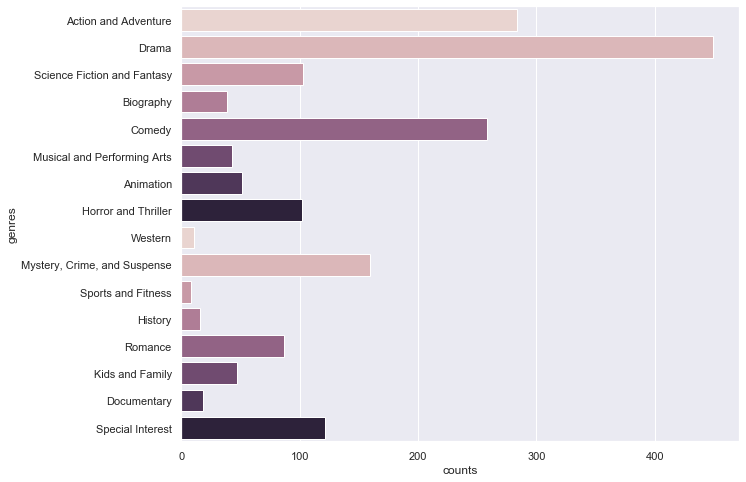

In [39]:
genre_plot = sns.barplot(x=genres_data['counts'], 
                         y=genres_data['genres'], 
                         palette=sns.cubehelix_palette(8)
                        )

Ratings are also important, as it determines the ages of the audience that can view the movies. While ratings do change based on locale, Microsoft is a specifically US-based company, and so this project will focus on US-based ratings.

In [40]:
ratings_df = pd.DataFrame()
ind = 0
for item in content_df['rating']:
    if type(item) is str:
        rating_temp = pd.DataFrame({'ratings':item, 'count':1},index=[ind])
        ratings_df = ratings_df.append(rating_temp)
        ind +=1
    else:
        pass    

ratings_df = ratings_df.groupby('ratings').count()

  ratings  count
0       G     17
1    NC17      1
2      NR     80
3      PG     73
4   PG-13    129


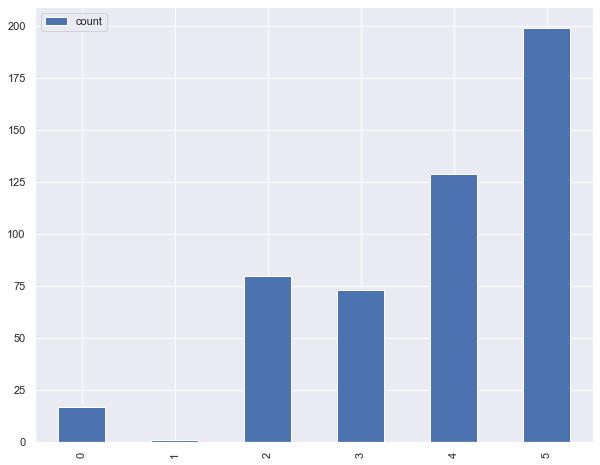

In [41]:
ratings_df = ratings_df.reset_index()
print(ratings_df.head())
ratings_df.plot(kind='bar')

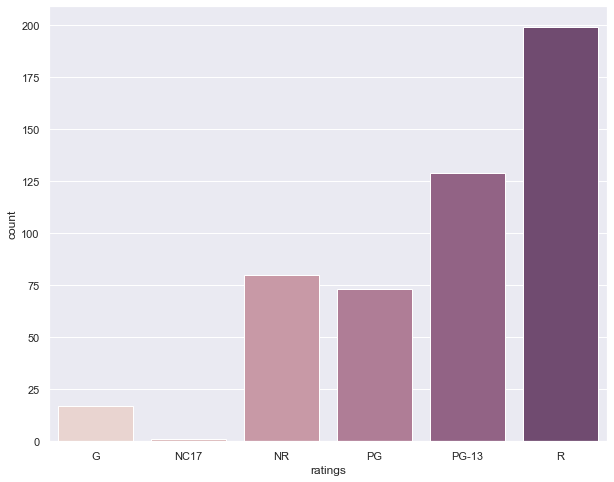

In [42]:


genre_plot = sns.barplot(x=ratings_df['ratings'],
                         y=ratings_df['count'],
                         palette=sns.cubehelix_palette(8),
                         
                        )

### Personnel Data Visualization
To determine who the company wants to bring on for this project, filtering by rating would be ideal, cross referencing by number of votes in order to also limit the search to widely-watched movies.

In [43]:
cur.execute("""SELECT DISTINCT tconst, 
                      primary_title , 
                      averagerating, 
                      numvotes,
                      category,
                      genres,
                      primary_name,
                      primary_profession            
               from movies
               JOIN principals using(tconst)
               JOIN workers using(nconst)
               WHERE (numvotes > 100000 AND
                      (category is "writer"))
               ORDER BY averagerating DESC
               LIMIT 25;
               """)
writers_df = make_dataframe()
writers_df.info()
writers_df.head(25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
tconst                25 non-null object
primary_title         25 non-null object
averagerating         25 non-null float64
numvotes              25 non-null int64
category              25 non-null object
genres                25 non-null object
primary_name          25 non-null object
primary_profession    25 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 1.7+ KB


,tconst,primary_title,averagerating,numvotes,category,genres,primary_name,primary_profession
0,tt4154796,Avengers: Endgame,8.8,441135,writer,"Action,Adventure,Sci-Fi",Jack Kirby,"writer,animation_department,miscellaneous"
1,tt4154796,Avengers: Endgame,8.8,441135,writer,"Action,Adventure,Sci-Fi",Christopher Markus,"writer,producer,actor"
2,tt4154796,Avengers: Endgame,8.8,441135,writer,"Action,Adventure,Sci-Fi",Stephen McFeely,"writer,producer,actor"
3,tt4154796,Avengers: Endgame,8.8,441135,writer,"Action,Adventure,Sci-Fi",Stan Lee,"producer,writer,actor"
4,tt0816692,Interstellar,8.6,1299334,writer,"Adventure,Drama,Sci-Fi",Jonathan Nolan,"writer,producer,director"
5,tt1675434,The Intouchables,8.5,677343,writer,"Biography,Comedy,Drama",Philippe Pozzo di Borgo,writer
6,tt4154756,Avengers: Infinity War,8.5,670926,writer,"Action,Adventure,Sci-Fi",Jack Kirby,"writer,animation_department,miscellaneous"
7,tt4154756,Avengers: Infinity War,8.5,670926,writer,"Action,Adventure,Sci-Fi",Christopher Markus,"writer,producer,actor"
8,tt4154756,Avengers: Infinity War,8.5,670926,writer,"Action,Adventure,Sci-Fi",Stephen McFeely,"writer,producer,actor"
9,tt4154756,Avengers: Infinity War,8.5,670926,writer,"Action,Adventure,Sci-Fi",Stan Lee,"producer,writer,actor"


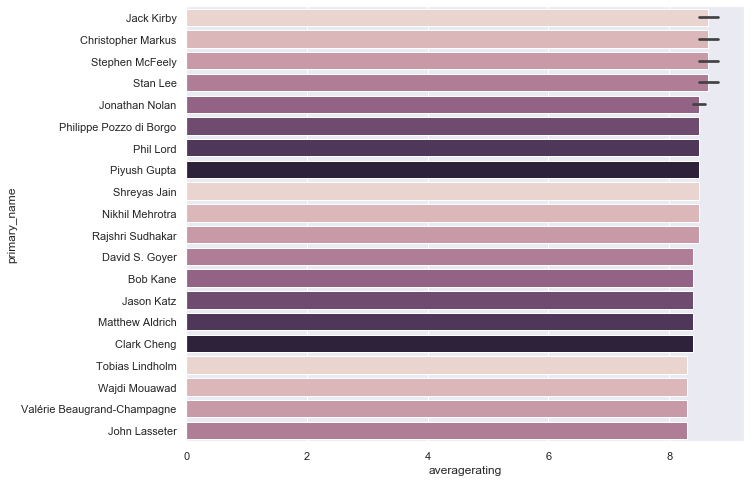

In [44]:
writers_plot = sns.barplot(x=writers_df['averagerating'], 
                         y=writers_df['primary_name'], 
                         palette=sns.cubehelix_palette(8)
                        )

In [45]:
cur.execute("""SELECT tconst, 
                      primary_title, 
                      averagerating, 
                      numvotes,
                      category,
                      genres,
                      primary_name,
                      primary_profession            
               from movies
               JOIN principals using(tconst)
               JOIN workers using(nconst)
               WHERE (numvotes > 100000 AND
                      (category is "director"))
               ORDER BY averagerating DESC
               LIMIT 25;
               """)
directors_df = make_dataframe()
directors_df.head(25)

,tconst,primary_title,averagerating,numvotes,category,genres,primary_name,primary_profession
0,tt5813916,The Mountain II,9.3,100568,director,"Action,Drama,War",Alper Caglar,"producer,writer,editor"
1,tt1375666,Inception,8.8,1841066,director,"Action,Adventure,Sci-Fi",Christopher Nolan,"writer,producer,director"
2,tt4154796,Avengers: Endgame,8.8,441135,director,"Action,Adventure,Sci-Fi",Anthony Russo,"producer,director,writer"
3,tt4154796,Avengers: Endgame,8.8,441135,director,"Action,Adventure,Sci-Fi",Joe Russo,"producer,director,writer"
4,tt0816692,Interstellar,8.6,1299334,director,"Adventure,Drama,Sci-Fi",Christopher Nolan,"writer,producer,director"
5,tt1675434,The Intouchables,8.5,677343,director,"Biography,Comedy,Drama",Olivier Nakache,"writer,director,producer"
6,tt1675434,The Intouchables,8.5,677343,director,"Biography,Comedy,Drama",Éric Toledano,"writer,director,producer"
7,tt4154756,Avengers: Infinity War,8.5,670926,director,"Action,Adventure,Sci-Fi",Anthony Russo,"producer,director,writer"
8,tt4154756,Avengers: Infinity War,8.5,670926,director,"Action,Adventure,Sci-Fi",Joe Russo,"producer,director,writer"
9,tt2582802,Whiplash,8.5,616916,director,"Drama,Music",Damien Chazelle,"producer,writer,director"


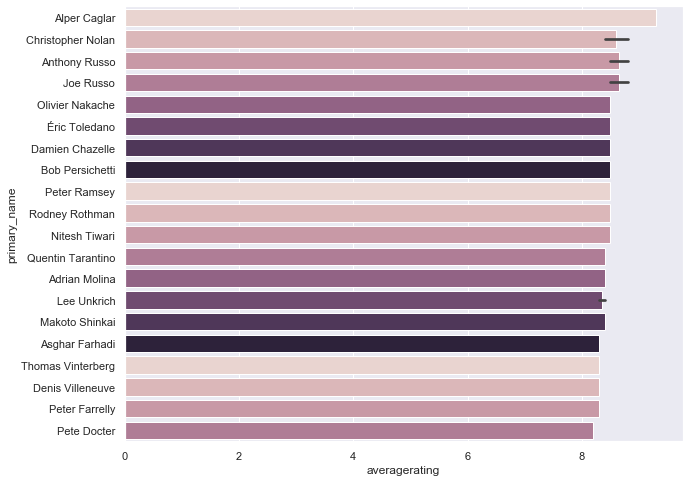

In [46]:
directors_df = sns.barplot(x=directors_df['averagerating'], 
                         y=directors_df['primary_name'], 
                         palette=sns.cubehelix_palette(8)
                        )

As far as actors go, it may be worth it to look at lesser-known but more highly-rated actors in order to lower costs and promote new talent. To do this, the qualification for number of votes is lowered, while retaining all of the other qualifications.

In [47]:
cur.execute("""SELECT tconst, 
                      primary_title, 
                      averagerating, 
                      numvotes,
                      category,
                      genres,
                      primary_name,
                      primary_profession            
               from movies
               JOIN principals using(tconst)
               JOIN workers using(nconst)
               WHERE (numvotes > 10000 AND
                      (category is "actor"))
               ORDER BY averagerating DESC
               LIMIT 500;
               """)
actors_df = make_dataframe()
actors_df.head()

,tconst,primary_title,averagerating,numvotes,category,genres,primary_name,primary_profession
0,tt2170667,Wheels,9.3,17308,actor,Drama,Donavon Warren,"producer,actor,director"
1,tt2170667,Wheels,9.3,17308,actor,Drama,Patrick Hume,"actor,miscellaneous"
2,tt2170667,Wheels,9.3,17308,actor,Drama,Kevin McCorkle,"actor,producer,miscellaneous"
3,tt5813916,The Mountain II,9.3,100568,actor,"Action,Drama,War",Ozan Agaç,"actor,writer,assistant_director"
4,tt5813916,The Mountain II,9.3,100568,actor,"Action,Drama,War",Bedii Akin,"actor,producer,writer"


In [48]:
actors_df.set_index('primary_name')
actors_df.groupby('primary_name').count()

,tconst,primary_title,averagerating,numvotes,category,genres,primary_profession
primary_name,,,,,,,
Aadhi,1,1,1,1,1,1,1
Aamir Khan,3,3,3,3,3,3,3
Abhay Deol,1,1,1,1,1,1,1
Abraham Attah,1,1,1,1,1,1,1
Achyuth Kumar,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
Yilmaz Erdogan,1,1,1,1,1,1,1
Yukito Nishii,2,2,2,2,2,2,2
Zachary Levi,1,1,1,1,1,1,1


While researching actors, it was realized that directors often choose actors and vice versa, so it's not feasible to keep actors in mind prior to choosing projects.

### Financial Data Visualization

Across the top 250 movies researched, it was found that the vast majority of them cost less than $250,0000,000

[]

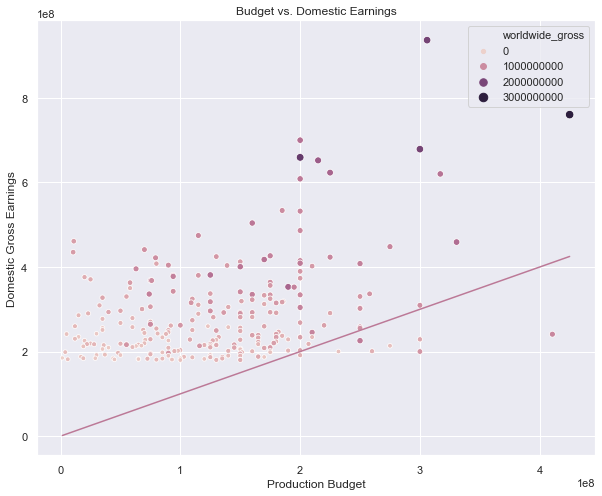

In [49]:
cur.execute("""SELECT movie, 
                      production_budget, 
                      domestic_gross, 
                      worldwide_gross
               from TNBudgets
               ORDER BY domestic_gross DESC
               LIMIT 250;""")
financial_df = make_dataframe()
financial_plot = sns.scatterplot(
    x=financial_df['production_budget'],
    y=financial_df['domestic_gross'],
    size=financial_df['worldwide_gross'],
    hue=financial_df['worldwide_gross']
    )

# Create line for reference to production_budget
x = np.linspace(min(financial_df['production_budget']),max(financial_df['production_budget']))
y = x
sns.lineplot(x=x, y=y, ax=financial_plot, color="#BC7997")


financial_plot.set_xlabel("Production Budget")
financial_plot.set_ylabel("Domestic Gross Earnings")
financial_plot.set_title("Budget vs. Domestic Earnings")
financial_plot.plot()

Text(0.5, 1.0, 'Movies by Production Values')

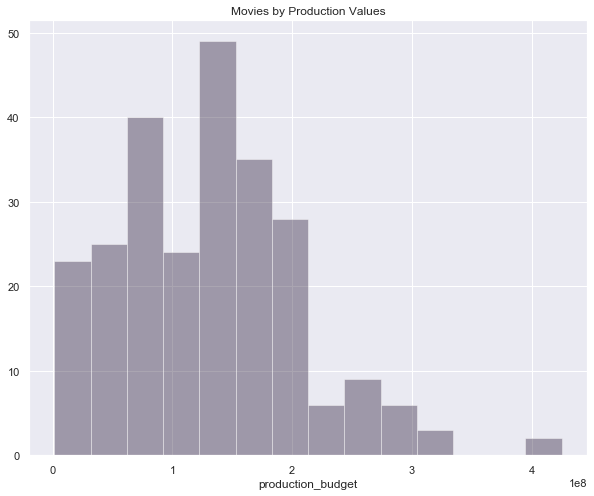

In [50]:
financial_plot = sns.distplot(financial_df['production_budget'], kde=False, color='#2C1E3D')
financial_plot.set_title("Movies by Production Values")

                                          movie  production_budget  \
0          Star Wars Ep. VII: The Force Awakens          306000000   
1                                        Avatar          425000000   
2                        Avengers: Infinity War          300000000   
3             Star Wars Ep. VIII: The Last Jedi          317000000   
4                       Avengers: Age of Ultron          330600000   
5                         The Dark Knight Rises          275000000   
6                                  Spider-Man 3          258000000   
7    Pirates of the Caribbean: At Worldâs End          300000000   
8   Pirates of the Caribbean: On Stranger Tides          410600000   
9                                Justice League          300000000   
10                      Solo: A Star Wars Story          275000000   
11                                      Tangled          260000000   
12                                      Spectre          300000000   
13                  

[]

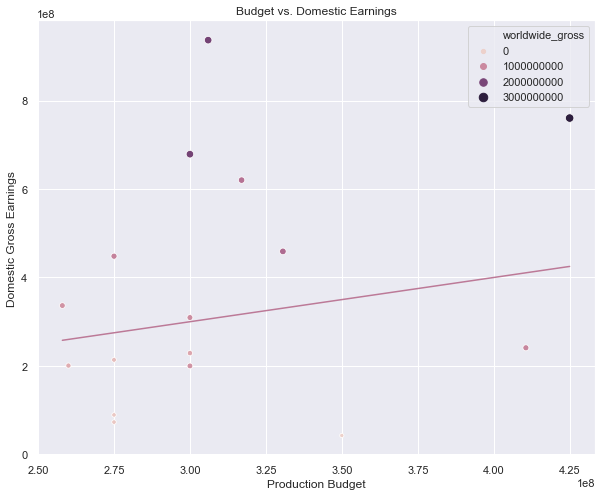

In [51]:
cur.execute("""SELECT movie, 
                      production_budget, 
                      domestic_gross, 
                      worldwide_gross
               from TNBudgets
               WHERE (production_budget > 250000000)
               ORDER BY domestic_gross DESC
               LIMIT 250;""") # Generate data via SQL Query
financial_df = make_dataframe() #Create Dataframe
print(financial_df) #Pulled data for presentation
financial_plot = sns.scatterplot(
    x=financial_df['production_budget'],
    y=financial_df['domestic_gross'],
    size=financial_df['worldwide_gross'],
    hue=financial_df['worldwide_gross']
    )
# To create line for reference of production budget
x = np.linspace(min(financial_df['production_budget']),max(financial_df['production_budget']))
y = x
sns.lineplot(x=x, y=y, ax=financial_plot, color="#BC7997")


financial_plot.set_xlabel("Production Budget")
financial_plot.set_ylabel("Domestic Gross Earnings")
financial_plot.set_title("Budget vs. Domestic Earnings")
financial_plot.plot()

                                           movie  production_budget  \
0           Star Wars Ep. VII: The Force Awakens          306000000   
1                                         Avatar          425000000   
2                                  Black Panther          200000000   
3                         Avengers: Infinity War          300000000   
4                                        Titanic          200000000   
5                                 Jurassic World          215000000   
6                                   The Avengers          225000000   
7              Star Wars Ep. VIII: The Last Jedi          317000000   
8                                  Incredibles 2          200000000   
9                                The Dark Knight          185000000   
10                  Rogue One: A Star Wars Story          200000000   
11                          Beauty and the Beast          160000000   
12                                  Finding Dory          200000000   
13    

[]

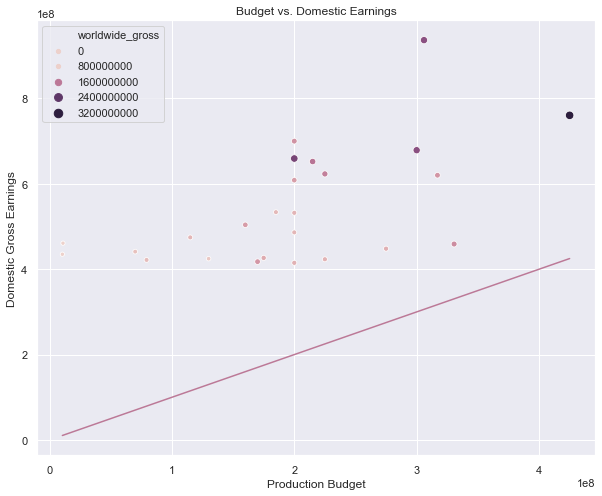

In [52]:
cur.execute("""SELECT movie, 
                      production_budget, 
                      domestic_gross, 
                      worldwide_gross
               from TNBudgets
               ORDER BY domestic_gross DESC
               LIMIT 25;""") # Generate data via SQL Query
financial_df = make_dataframe() #Create Dataframe
print(financial_df) #Pulled data for presentation
financial_plot = sns.scatterplot(
    x=financial_df['production_budget'],
    y=financial_df['domestic_gross'],
    size=financial_df['worldwide_gross'],
    hue=financial_df['worldwide_gross']
    )
# To create line for reference of production budget
x = np.linspace(min(financial_df['production_budget']),max(financial_df['production_budget']))
y = x
sns.lineplot(x=x, y=y, ax=financial_plot, color="#BC7997")


financial_plot.set_xlabel("Production Budget")
financial_plot.set_ylabel("Domestic Gross Earnings")
financial_plot.set_title("Budget vs. Domestic Earnings")
financial_plot.plot()

Conclusion
Video (10 minutes)
Cut presentation down some
Data Science LifeCycle

---

# Conclusion
Overall, Microsoft's move into the movie business would likely result in solid returns on investments. Looking at content, genre and rating are likely the most important focuses, as those are the biggest "filters" that people use to choose what movies they go to see. Next, personnel concerns become relevant, as directors and writers are typically genre-specific and it's important to ensure that those decisions are in line with the goals of the specific film production. Finally, the financials of the production must align with the goals of the company and what needs to be gathered from the data is what the general investment would need to be in order to promote that ROI.

With those considerations in mind, the recommendations that the data supports are as follows. Based on the trends of the past 10-15 years, it is best to produce action, adventure, drama, and comedy movies, as they tend to do best in the box office, as well as doing best with ratings. In terms of audience, the most commonly seen ratings in profitable movies are typically PG-13 to R, with G and NC-17 being exceptionally rare. As far as directors go, there are a few recommendations that can be made based on recent history, the primary ones at this point being Christopher Nolan and Quentin Tarantino. In terms of writers, Christopher Nolan typically works with his family, in the form of Jonathan Nolan, and Quentin Tarantino typically does his own writing, but we have options for that. The final area for recommendations is the financials, and the data supports a budget of $250,000,000 or less, as among the highest-grossing films of the last 25 years, as that budget typically gives a solid ROI.

Overall, it appears that there is a formula to building this part of the business. Choose popular genres, with well-known directors, and only invest as much as is necessary, which in the vast majority of cases is exceptionally rare from a new studio.